# **Segmentação de clientes**

In [36]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# pip install yellowbrick

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

%matplotlib inline

In [37]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [38]:
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

## Carregamento e análise de dados

In [39]:
df_vendas = pd.read_csv('data/tfvenda.csv')
df_clientes = pd.read_csv('data/DimCliente.csv')
df_produtos = pd.read_csv('data/DimProduto.csv')
df_tempo = pd.read_csv('data/DimTempo.csv')

In [40]:
df_vendas

,VendaId,DataId,ClienteId,ProdutoId,Quantidade,PrecoUnitario,PercentagemDesconto,ValorTotal,Canal
0,1,2012-11-24,453,64,3,84.55,4.0,253.65,Loja Física
1,2,2010-11-24,113,140,5,161.37,25.0,806.85,Loja Física
2,3,2010-07-07,202,27,4,62.03,13.0,248.11,Loja Física
3,4,2019-05-10,560,123,5,214.03,49.0,1070.15,Loja Física
4,5,2019-04-15,168,21,4,129.40,29.0,517.58,Loja Física
...,...,...,...,...,...,...,...,...,...
15878,17879,2022-09-01,1094,90,2,642.87,21.0,1285.73,Online
15879,17880,2024-01-27,1298,61,1,203.33,16.0,203.33,Online
15880,17881,2021-03-19,2032,123,3,165.25,44.0,495.74,Online
15881,17882,2023-01-09,458,22,5,206.56,5.0,1032.80,Online


In [41]:
df_clientes

,ClienteId,Nome,Sexo,EstadoCivil,Profissao,Concelho,Distrito,DataNascimento
0,100,João Garcia,M,Divorciado,Comerciante,Celorico de Basto,Braga,1985-10-26
1,101,Gustavo Andrade,M,Solteiro,Analista de Dados,Vizela,Braga,1947-05-31
2,102,Salomé Matos,F,Divorciado,Gestor de Projetos,Póvoa de Varzim,Porto,2004-10-17
3,103,Anita de Silva,F,Casado,Cozinheiro,Sabugal,Guarda,1987-03-23
4,104,Diana Castro-Nogueira,F,Casado,Técnico de Marketing,Bragança,Bragança,1956-09-25
...,...,...,...,...,...,...,...,...
1986,2095,Miguel Antunes,M,Viúvo,Técnico de Marketing,Guarda,Guarda,1997-08-08
1987,2096,Isabel Cardoso,F,Viúvo,Carpinteiro,Celorico de Basto,Braga,1989-05-05
1988,2097,Nádia Carneiro,F,Viúvo,Farmacêutico,Braga,Braga,1997-11-03
1989,2098,Brian Costa,M,Casado,Programador,Valongo,Porto,1994-06-05


In [42]:
df_produtos

,ProdutoId,Nome,Marca,Categoria
0,1,Rato Logitech MX Master,Logitech,Perifericos
1,2,Logitech Rato MX Anywhere,Logitech,Perifericos
2,3,Teclado Mecânico Corsair K70,Corsair,Perifericos
3,4,Teclado Gaming Razer BlackWidow,Razer,Perifericos
4,5,"Monitor Dell 24"",Dell,Monitores\n6,Monitor 27 ...",HP,Monitores
...,...,...,...,...
168,171,Rato SteelSeries Rival 5,Logitech,Perifericos
169,172,Teclado Razer Pro Type,Acer,Monitores
170,173,"Monitor 27 ASUS ProArt""",BenQ,Monitores
171,174,Headset Sennheiser HD 560S,Sony,Audio


In [43]:
df_tempo

,DataId,Mes,Trimestre,Ano,FimDeSemana,Feriado
0,2010-01-01,1,1,2010,N,S
1,2010-01-02,1,1,2010,S,N
2,2010-01-03,1,1,2010,S,N
3,2010-01-04,1,1,2010,N,N
4,2010-01-05,1,1,2010,N,N
...,...,...,...,...,...,...
5177,2025-04-07,4,2,2025,N,N
5178,2025-04-08,4,2,2025,N,N
5179,2025-04-09,4,2,2025,N,N
5180,2025-04-10,4,2,2025,N,N


In [44]:
df_vendas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15883 entries, 0 to 15882
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   VendaId              15883 non-null  int64  
 1   DataId               15883 non-null  object 
 2   ClienteId            15883 non-null  int64  
 3   ProdutoId            15883 non-null  int64  
 4   Quantidade           15883 non-null  int64  
 5   PrecoUnitario        15883 non-null  float64
 6   PercentagemDesconto  15883 non-null  float64
 7   ValorTotal           15883 non-null  float64
 8   Canal                15883 non-null  object 
dtypes: float64(3), int64(4), object(2)
memory usage: 1.1+ MB


In [45]:
df_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1991 entries, 0 to 1990
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ClienteId       1991 non-null   int64 
 1   Nome            1991 non-null   object
 2   Sexo            1991 non-null   object
 3   EstadoCivil     1991 non-null   object
 4   Profissao       1991 non-null   object
 5   Concelho        1991 non-null   object
 6   Distrito        1991 non-null   object
 7   DataNascimento  1991 non-null   object
dtypes: int64(1), object(7)
memory usage: 124.6+ KB


In [46]:
df_produtos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ProdutoId  173 non-null    int64 
 1   Nome       173 non-null    object
 2   Marca      173 non-null    object
 3   Categoria  173 non-null    object
dtypes: int64(1), object(3)
memory usage: 5.5+ KB


In [47]:
df_tempo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5182 entries, 0 to 5181
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   DataId       5182 non-null   object
 1   Mes          5182 non-null   int64 
 2   Trimestre    5182 non-null   int64 
 3   Ano          5182 non-null   int64 
 4   FimDeSemana  5182 non-null   object
 5   Feriado      5182 non-null   object
dtypes: int64(3), object(3)
memory usage: 243.0+ KB


## Limpeza e transformação de dados

### Missing values

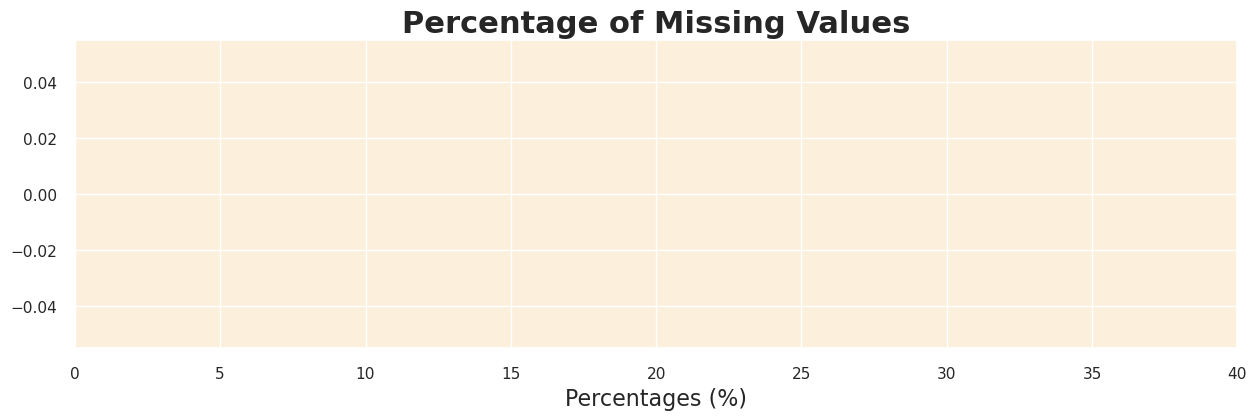

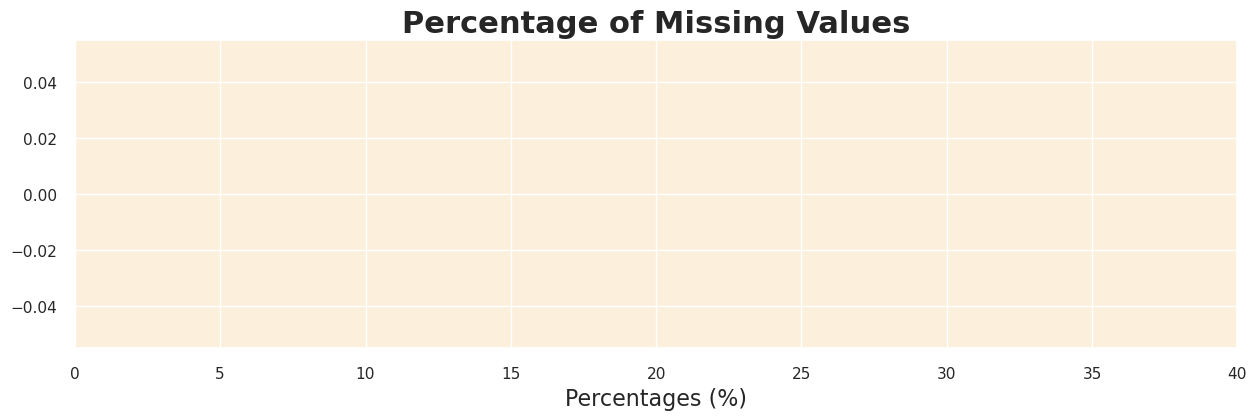

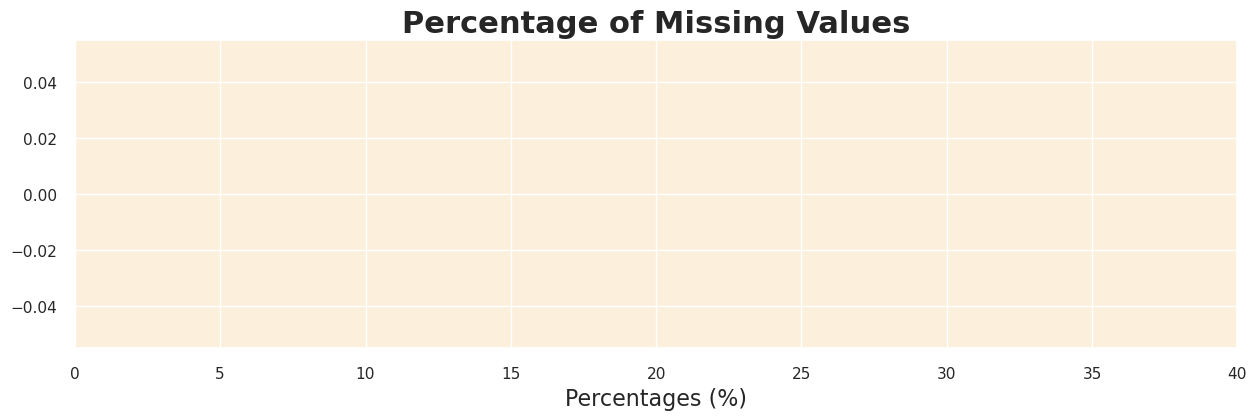

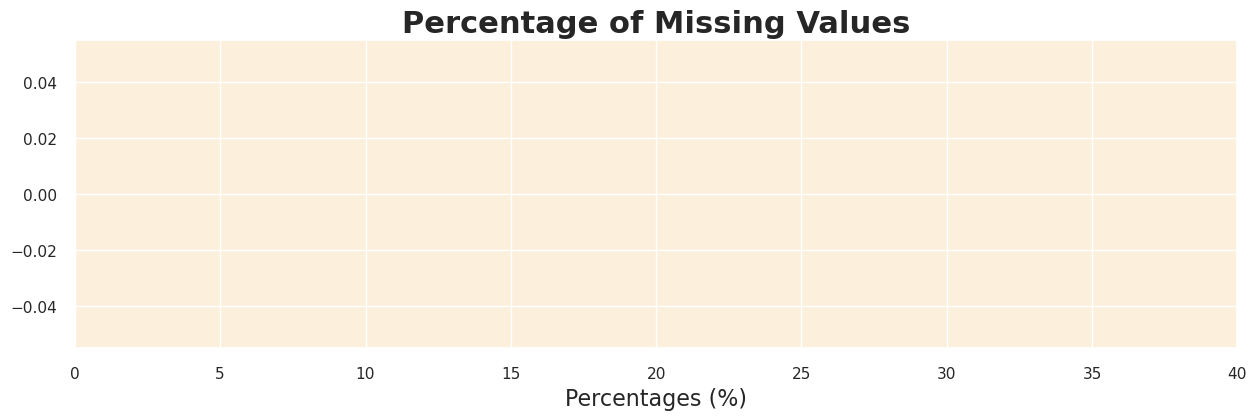

In [48]:
dfs = [df_vendas, df_clientes, df_produtos, df_tempo]

for df in dfs:
    missing_data = df.isnull().sum()
    missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100

    missing_percentage.sort_values(ascending=True, inplace=True)

    fig, ax = plt.subplots(figsize=(15, 4))
    ax.barh(missing_percentage.index, missing_percentage, color='#ff6200')

    for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
        ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')

    ax.set_xlim([0, 40])

    plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
    plt.xlabel('Percentages (%)', fontsize=16)
    plt.show()

In [49]:
for df in dfs:
    df.isnull().sum().sum()

### Duplicados

In [50]:
for df in dfs:
    duplicate_rows = df[df.duplicated(keep=False)]
    duplicate_rows.head(10)
    if duplicate_rows.empty:
        print(f"No duplicate rows in {df.columns[0]}")

No duplicate rows in VendaId
No duplicate rows in ClienteId
No duplicate rows in ProdutoId
No duplicate rows in DataId


## Feature engineering

### PrecoFinal
Preço final de uma compra considerando a quntidade, preço unitário e o desconto por unidade

In [51]:
df_vendas['PrecoFinal'] = df_vendas['PrecoUnitario'] * df_vendas['Quantidade'] * (1 - df_vendas['PercentagemDesconto']/100)
df_vendas.head(3)

,VendaId,DataId,ClienteId,ProdutoId,Quantidade,PrecoUnitario,PercentagemDesconto,ValorTotal,Canal,PrecoFinal
0,1,2012-11-24,453,64,3,84.55,4.0,253.65,Loja Física,243.5040
1,2,2010-11-24,113,140,5,161.37,25.0,806.85,Loja Física,605.1375
2,3,2010-07-07,202,27,4,62.03,13.0,248.11,Loja Física,215.8644


### Idade

In [52]:
df_clientes['DataNascimento'] = pd.to_datetime(df_clientes['DataNascimento'])

today = pd.Timestamp.today()
df_clientes['Idade'] = df_clientes['DataNascimento'].apply(lambda x: today.year - x.year - ((today.month, today.day) < (x.month, x.day)))

df_clientes.head(3)

,ClienteId,Nome,Sexo,EstadoCivil,Profissao,Concelho,Distrito,DataNascimento,Idade
0,100,João Garcia,M,Divorciado,Comerciante,Celorico de Basto,Braga,1985-10-26,39
1,101,Gustavo Andrade,M,Solteiro,Analista de Dados,Vizela,Braga,1947-05-31,77
2,102,Salomé Matos,F,Divorciado,Gestor de Projetos,Póvoa de Varzim,Porto,2004-10-17,20


### Frequencia
Total de transações e de produtos comprados

In [53]:
total_transacoes = df_vendas.groupby('ClienteId')['VendaId'].nunique().reset_index()
total_transacoes.rename(columns={'VendaId': 'TotalTransacoes'}, inplace=True)

total_compras = df_vendas.groupby('ClienteId')['Quantidade'].sum().reset_index()
total_compras.rename(columns={'Quantidade': 'TotalCompras'}, inplace=True)

df_clientes = pd.merge(df_clientes, total_transacoes, on='ClienteId', how='left')
df_clientes = pd.merge(df_clientes, total_compras, on='ClienteId', how='left')

df_clientes.head(3)

,ClienteId,Nome,Sexo,EstadoCivil,Profissao,Concelho,Distrito,DataNascimento,Idade,TotalTransacoes,TotalCompras
0,100,João Garcia,M,Divorciado,Comerciante,Celorico de Basto,Braga,1985-10-26,39,30,91
1,101,Gustavo Andrade,M,Solteiro,Analista de Dados,Vizela,Braga,1947-05-31,77,30,98
2,102,Salomé Matos,F,Divorciado,Gestor de Projetos,Póvoa de Varzim,Porto,2004-10-17,20,31,97


### Total gasto e Valor Médio de transações

In [54]:
df_vendas['Total_Spend'] = df_vendas['PrecoUnitario'] * df_vendas['Quantidade'] * (1 - df_vendas['PercentagemDesconto']/100)
total_spend = df_vendas.groupby('ClienteId')['Total_Spend'].sum().reset_index()

total_transactions = df_vendas.groupby('ClienteId').size().reset_index(name='Total_Transactions')

average_transaction_value = total_spend.merge(total_transactions, on='ClienteId')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

customer_data = df_clientes.copy()

customer_data = pd.merge(customer_data, total_spend, on='ClienteId', how='left')
customer_data = pd.merge(customer_data, average_transaction_value[['ClienteId', 'Average_Transaction_Value']], on='ClienteId', how='left')

customer_data.head(3)

,ClienteId,Nome,Sexo,EstadoCivil,Profissao,Concelho,Distrito,DataNascimento,Idade,TotalTransacoes,TotalCompras,Total_Spend,Average_Transaction_Value
0,100,João Garcia,M,Divorciado,Comerciante,Celorico de Basto,Braga,1985-10-26,39,30,91,18650.0270,621.667567
1,101,Gustavo Andrade,M,Solteiro,Analista de Dados,Vizela,Braga,1947-05-31,77,30,98,14033.2457,467.774857
2,102,Salomé Matos,F,Divorciado,Gestor de Projetos,Póvoa de Varzim,Porto,2004-10-17,20,31,97,17554.6157,566.277926


### Diversidade de produtos

Produtos unicos comprados

In [55]:
unique_products_purchased = df_vendas.groupby('ClienteId')['ProdutoId'].nunique().reset_index()
unique_products_purchased.rename(columns={'ProdutoId': 'ProdutosUnicosComprados'}, inplace=True)

df_clientes = pd.merge(df_clientes, unique_products_purchased, on='ClienteId')

df_clientes.head(3)

,ClienteId,Nome,Sexo,EstadoCivil,Profissao,Concelho,Distrito,DataNascimento,Idade,TotalTransacoes,TotalCompras,ProdutosUnicosComprados
0,100,João Garcia,M,Divorciado,Comerciante,Celorico de Basto,Braga,1985-10-26,39,30,91,27
1,101,Gustavo Andrade,M,Solteiro,Analista de Dados,Vizela,Braga,1947-05-31,77,30,98,28
2,102,Salomé Matos,F,Divorciado,Gestor de Projetos,Póvoa de Varzim,Porto,2004-10-17,20,31,97,30


### Media de dias entre compras e Dia e Hora favoritos para comprar

In [56]:
df_vendas['DataCompra'] = pd.to_datetime(df_vendas['DataId'])

df_vendas['Day_Of_Week'] = df_vendas['DataCompra'].dt.dayofweek
df_vendas['Hour'] = 12

df_vendas = df_vendas.sort_values(['ClienteId', 'DataCompra'])

df_vendas['InvoiceDay'] = df_vendas['DataCompra'].dt.date
days_between_purchases = df_vendas.groupby('ClienteId')['InvoiceDay'].apply(lambda x: (x.diff()).dropna().apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('ClienteId').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

favorite_shopping_day = df_vendas.groupby(['ClienteId', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('ClienteId')['Count'].idxmax()][['ClienteId', 'Day_Of_Week']]

favorite_shopping_hour = df_vendas.groupby(['ClienteId', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('ClienteId')['Count'].idxmax()][['ClienteId', 'Hour']]

customer_data = df_clientes.copy()
customer_data = pd.merge(customer_data, average_days_between_purchases, on='ClienteId', how='left')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='ClienteId', how='left')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='ClienteId', how='left')

day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
customer_data['Favorite_Shopping_Day'] = customer_data['Day_Of_Week'].map(day_mapping)

customer_data.head(3)

,ClienteId,Nome,Sexo,EstadoCivil,Profissao,Concelho,Distrito,DataNascimento,Idade,TotalTransacoes,TotalCompras,ProdutosUnicosComprados,Average_Days_Between_Purchases,Day_Of_Week,Hour,Favorite_Shopping_Day
0,100,João Garcia,M,Divorciado,Comerciante,Celorico de Basto,Braga,1985-10-26,39,30,91,27,168.827586,0,12,Monday
1,101,Gustavo Andrade,M,Solteiro,Analista de Dados,Vizela,Braga,1947-05-31,77,30,98,28,190.310345,4,12,Friday
2,102,Salomé Matos,F,Divorciado,Gestor de Projetos,Póvoa de Varzim,Porto,2004-10-17,20,31,97,30,162.733333,6,12,Sunday


### Media de gastos mensais

In [57]:
df_vendas['DataCompra'] = pd.to_datetime(df_vendas['DataId'])

df_vendas['Year'] = df_vendas['DataCompra'].dt.year
df_vendas['Month'] = df_vendas['DataCompra'].dt.month

if 'Total_Spend' not in df_vendas.columns:
    df_vendas['Total_Spend'] = df_vendas['PrecoUnitario'] * df_vendas['Quantidade'] * (1 - df_vendas['PercentagemDesconto']/100)

monthly_spending = df_vendas.groupby(['ClienteId', 'Year', 'Month'])['Total_Spend'].sum().reset_index()

seasonal_buying_patterns = monthly_spending.groupby('ClienteId')['Total_Spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

def calculate_trend(spend_data):
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    else:
        return 0

spending_trends = monthly_spending.groupby('ClienteId')['Total_Spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spend': 'Spending_Trend'}, inplace=True)

if 'customer_data' not in locals():
    customer_data = df_clientes.copy()

customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='ClienteId', how='left')
customer_data = pd.merge(customer_data, spending_trends, on='ClienteId', how='left')

customer_data.head(3)

,ClienteId,Nome,Sexo,EstadoCivil,Profissao,Concelho,Distrito,DataNascimento,Idade,TotalTransacoes,TotalCompras,ProdutosUnicosComprados,Average_Days_Between_Purchases,Day_Of_Week,Hour,Favorite_Shopping_Day,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,100,João Garcia,M,Divorciado,Comerciante,Celorico de Basto,Braga,1985-10-26,39,30,91,27,168.827586,0,12,Monday,690.741741,342.158729,-3.993210
1,101,Gustavo Andrade,M,Solteiro,Analista de Dados,Vizela,Braga,1947-05-31,77,30,98,28,190.310345,4,12,Friday,467.774857,365.963484,-1.013417
2,102,Salomé Matos,F,Divorciado,Gestor de Projetos,Póvoa de Varzim,Porto,2004-10-17,20,31,97,30,162.733333,6,12,Sunday,626.950561,417.946527,-0.389763


In [58]:
customer_data['ClienteId'] = customer_data['ClienteId'].astype(str)

customer_data = customer_data.convert_dtypes()

customer_data.head(10)

,ClienteId,Nome,Sexo,EstadoCivil,Profissao,Concelho,Distrito,DataNascimento,Idade,TotalTransacoes,TotalCompras,ProdutosUnicosComprados,Average_Days_Between_Purchases,Day_Of_Week,Hour,Favorite_Shopping_Day,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,100,João Garcia,M,Divorciado,Comerciante,Celorico de Basto,Braga,1985-10-26,39,30,91,27,168.827586,0,12,Monday,690.741741,342.158729,-3.99321
1,101,Gustavo Andrade,M,Solteiro,Analista de Dados,Vizela,Braga,1947-05-31,77,30,98,28,190.310345,4,12,Friday,467.774857,365.963484,-1.013417
2,102,Salomé Matos,F,Divorciado,Gestor de Projetos,Póvoa de Varzim,Porto,2004-10-17,20,31,97,30,162.733333,6,12,Sunday,626.950561,417.946527,-0.389763
3,103,Anita de Silva,F,Casado,Cozinheiro,Sabugal,Guarda,1987-03-23,38,39,128,36,109.789474,1,12,Tuesday,874.879165,509.424617,6.329541
4,104,Diana Castro-Nogueira,F,Casado,Técnico de Marketing,Bragança,Bragança,1956-09-25,68,25,68,24,208.5,5,12,Saturday,682.680423,389.821981,25.012468
5,105,Sandro Nunes-Magalhães,M,Divorciado,Arquiteto,Arcos de Valdevez,Viana do Castelo,1967-07-06,57,41,129,35,130.825,3,12,Thursday,692.878332,365.988879,-2.86165
6,106,Jorge Pinto,M,Casado,Farmacêutico,Vidigueira,Beja,1981-04-03,44,38,115,34,134.810811,3,12,Thursday,555.367297,413.042209,6.937962
7,107,Rui Fernandes-Leal,M,Viúvo,Cozinheiro,Cabeceiras de Basto,Braga,1975-03-07,50,27,86,26,206.730769,0,12,Monday,669.97875,443.074777,14.508418
8,108,Carminho da Jesus,F,Divorciado,Estudante,Guimarães,Braga,1948-10-08,76,34,100,31,147.181818,5,12,Saturday,736.773146,497.132228,9.49989
9,109,Inês Castro,F,Divorciado,Médico,Felgueiras,Porto,1993-11-27,31,36,96,34,114.142857,0,12,Monday,666.744097,418.810751,3.196195


In [59]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1991 entries, 0 to 1990
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   ClienteId                       1991 non-null   string        
 1   Nome                            1991 non-null   string        
 2   Sexo                            1991 non-null   string        
 3   EstadoCivil                     1991 non-null   string        
 4   Profissao                       1991 non-null   string        
 5   Concelho                        1991 non-null   string        
 6   Distrito                        1991 non-null   string        
 7   DataNascimento                  1991 non-null   datetime64[ns]
 8   Idade                           1991 non-null   Int64         
 9   TotalTransacoes                 1991 non-null   Int64         
 10  TotalCompras                    1991 non-null   Int64         
 11  Prod

## Deteção e tratamento de outliers

In [60]:
model = IsolationForest(contamination=0.05, random_state=0)

numeric_columns = customer_data.select_dtypes(include=['number']).columns

numeric_data = customer_data[numeric_columns].fillna(customer_data[numeric_columns].mean())

customer_data['Outlier_Scores'] = model.fit_predict(numeric_data.to_numpy())

customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

customer_data.head()

,ClienteId,Nome,Sexo,EstadoCivil,Profissao,Concelho,Distrito,DataNascimento,Idade,TotalTransacoes,...,ProdutosUnicosComprados,Average_Days_Between_Purchases,Day_Of_Week,Hour,Favorite_Shopping_Day,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Outlier_Scores,Is_Outlier
0,100,João Garcia,M,Divorciado,Comerciante,Celorico de Basto,Braga,1985-10-26,39,30,...,27,168.827586,0,12,Monday,690.741741,342.158729,-3.99321,-1,1
1,101,Gustavo Andrade,M,Solteiro,Analista de Dados,Vizela,Braga,1947-05-31,77,30,...,28,190.310345,4,12,Friday,467.774857,365.963484,-1.013417,-1,1
2,102,Salomé Matos,F,Divorciado,Gestor de Projetos,Póvoa de Varzim,Porto,2004-10-17,20,31,...,30,162.733333,6,12,Sunday,626.950561,417.946527,-0.389763,-1,1
3,103,Anita de Silva,F,Casado,Cozinheiro,Sabugal,Guarda,1987-03-23,38,39,...,36,109.789474,1,12,Tuesday,874.879165,509.424617,6.329541,-1,1
4,104,Diana Castro-Nogueira,F,Casado,Técnico de Marketing,Bragança,Bragança,1956-09-25,68,25,...,24,208.5,5,12,Saturday,682.680423,389.821981,25.012468,1,0


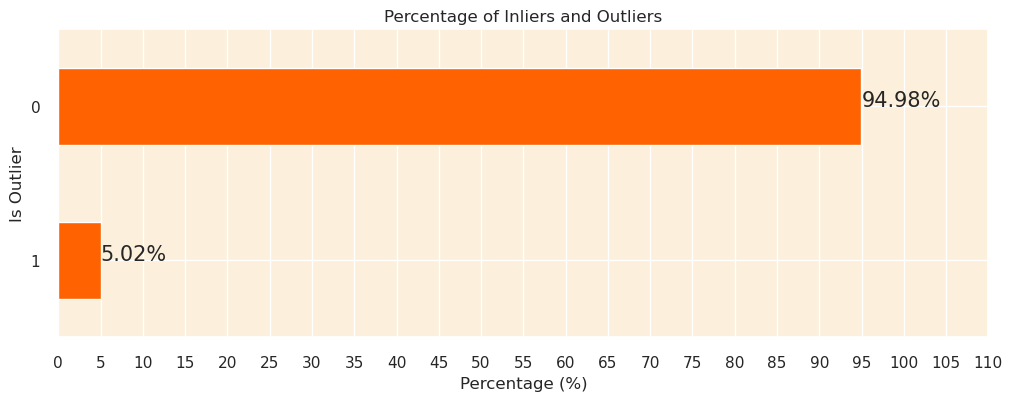

In [61]:
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100

plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh', color='#ff6200')

for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

In [62]:
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

customer_data_cleaned.reset_index(drop=True, inplace=True)

In [63]:
customer_data_cleaned.shape[0]

1891

## Correlation analysis

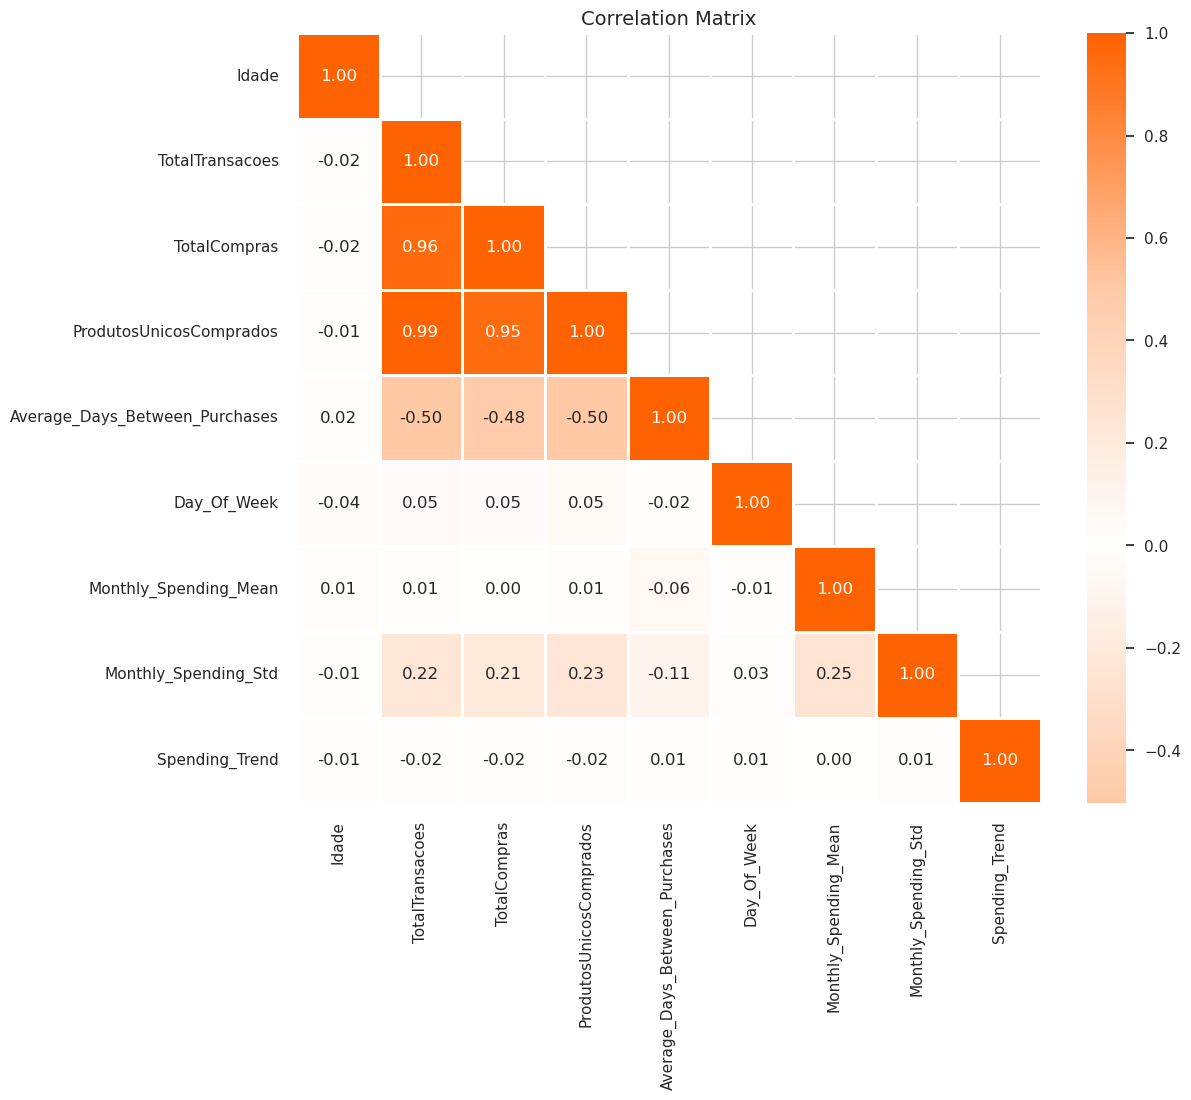

In [64]:
sns.set_style('whitegrid')

numeric_columns = customer_data_cleaned.select_dtypes(include=['number']).columns
numeric_columns = [col for col in numeric_columns if col != 'Hour']

corr = customer_data_cleaned[numeric_columns].corr()

colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

## Feature scaling

In [65]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['ClienteId', 'Day_Of_Week', 'Nome', 'Sexo', 'DataId', 'DataCompra', 'InvoiceDay', 'Favorite_Shopping_Day', 'Concelho', 'Distrito', 'DataNascimento', 'EstadoCivil', 'Profissao']

# List of columns that need to be scaled
columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
customer_data_scaled = customer_data_cleaned.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

# Display the first few rows of the scaled data
customer_data_scaled.head()

,ClienteId,Nome,Sexo,EstadoCivil,Profissao,Concelho,Distrito,DataNascimento,Idade,TotalTransacoes,TotalCompras,ProdutosUnicosComprados,Average_Days_Between_Purchases,Day_Of_Week,Hour,Favorite_Shopping_Day,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,104,Diana Castro-Nogueira,F,Casado,Técnico de Marketing,Bragança,Bragança,1956-09-25,1.061077,4.535505,3.852251,4.629786,-1.264881,5,0.0,Saturday,0.633733,0.456363,0.139737
1,114,Renato Freitas,M,Casado,Aposentado,Vizela,Braga,1961-10-14,0.788233,5.036068,5.072018,4.897447,-1.257118,3,0.0,Thursday,0.097603,1.230351,-0.086134
2,116,Luca Anjos,M,Casado,Advogado,Braga,Braga,1973-08-17,0.133407,5.286349,4.828065,4.362125,-1.391035,2,0.0,Wednesday,0.822105,1.137871,-0.131523
3,117,Mara-Teresa Nogueira,F,Casado,Aposentado,Guimarães,Braga,1970-12-19,0.297113,3.784661,2.795121,3.826802,-1.204756,1,0.0,Tuesday,0.496365,0.479134,-0.048989
4,120,Kévim Matos,M,Divorciado,Carpinteiro,Celorico de Basto,Braga,1967-10-18,0.460820,6.287474,6.454420,5.968091,-1.387355,2,0.0,Wednesday,-0.085180,0.533849,-0.071343


## Dimensionality reduction

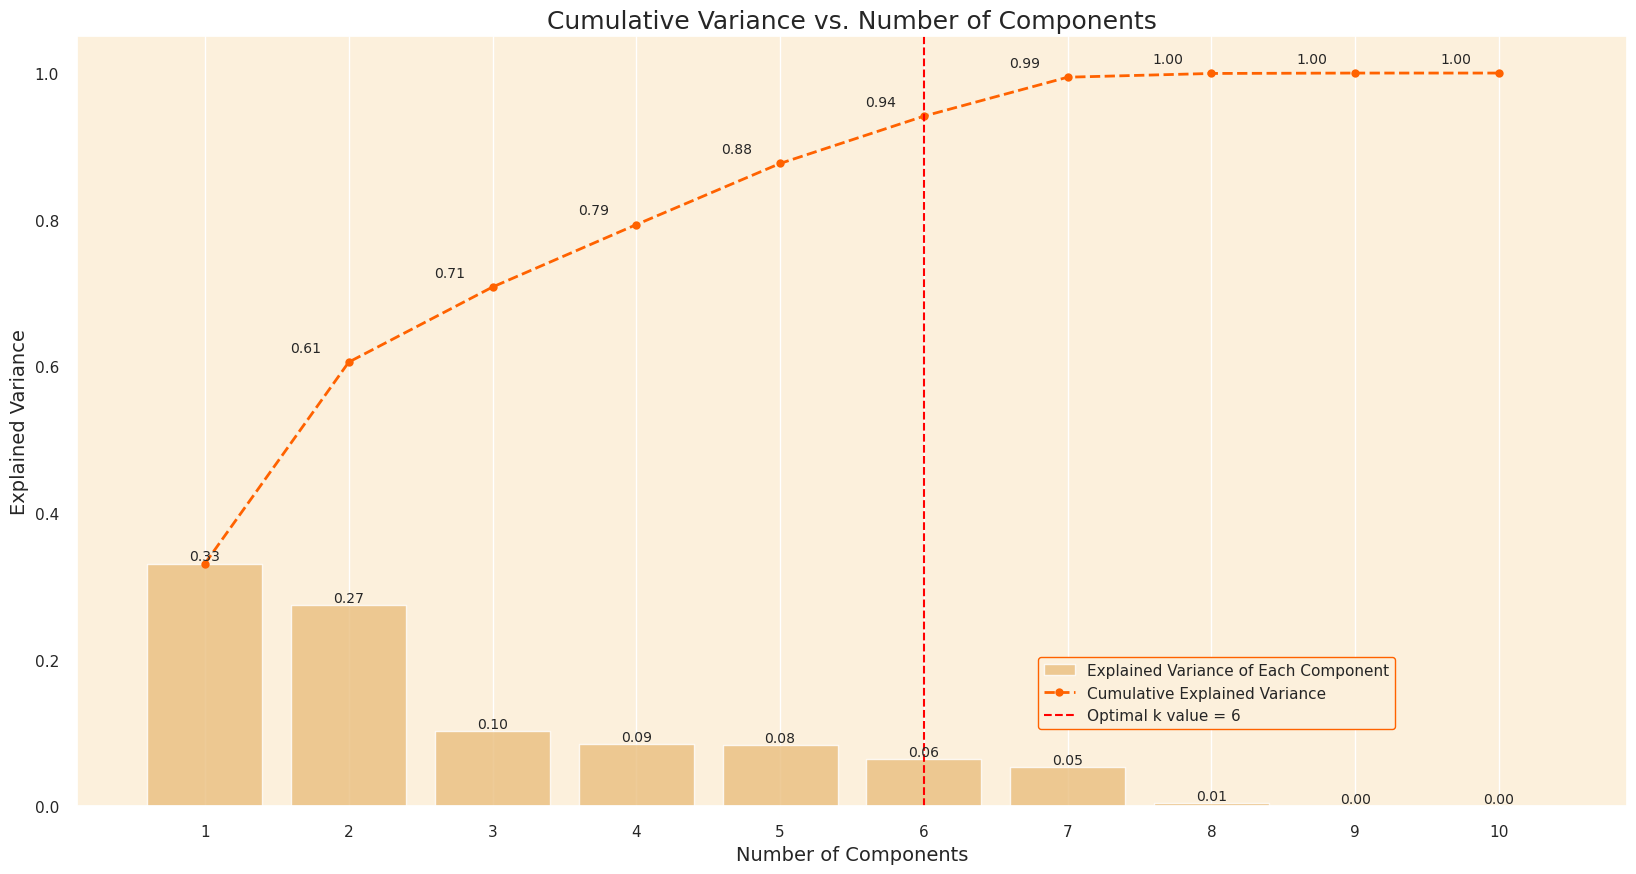

In [66]:
# Make sure we use only numeric columns for PCA
numeric_columns = customer_data_scaled.select_dtypes(include=['number']).columns
customer_data_numeric = customer_data_scaled[numeric_columns]

# Set CustomerID as the index if it's not already
if 'ClienteId' in customer_data_numeric.columns:
    customer_data_numeric.set_index('ClienteId', inplace=True)

# Fill missing values with the mean of each column
customer_data_numeric_imputed = customer_data_numeric.fillna(customer_data_numeric.mean())

# Apply PCA
pca = PCA().fit(customer_data_numeric_imputed)

# Calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Set the optimal k value (based on our analysis, we can choose 6)
optimal_k = 6

# Set seaborn plot style
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

# Plot the cumulative explained variance against the number of components
plt.figure(figsize=(20, 10))

# Bar chart for the explained variance of each component
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                     y=explained_variance_ratio,
                     color='#fcc36d',
                     alpha=0.8)

# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                    marker='o', linestyle='--', color='#ff6200', linewidth=2)

# Plot optimal k value line
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}')

# Set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Customize ticks and legend
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
          labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
          loc=(0.62, 0.1),
          frameon=True,
          framealpha=1.0,
          edgecolor='#ff6200')

# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')
plt.show()

In [67]:
# Creating a PCA object with 6 components
pca = PCA(n_components=6)

# Fitting and transforming the original data to the new PCA dataframe
customer_data_pca = pca.fit_transform(customer_data_numeric_imputed)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
customer_data_pca.index = customer_data_numeric_imputed.index

In [68]:
# Displaying the resulting dataframe based on the PCs
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,4.582298,6.460906,-0.207828,-0.713230,1.078645,0.078094
1,2.994714,8.134151,-0.301094,-0.600078,0.735712,0.994482
2,1.982503,8.193347,0.185315,-0.204048,0.156376,0.447645
3,0.372153,6.200532,-0.140310,-0.234015,0.298740,0.056478
4,2.554965,10.235507,-1.193418,-0.366279,0.595578,0.838154


In [69]:
# Define a function to highlight the top 3 absolute values in each column of a dataframe
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:  #ffeacc' if i in top3 else '' for i in column.index]

# Garante que usas as mesmas colunas que foram usadas no PCA
features_used = customer_data_numeric_imputed.columns[:pca.components_.shape[1]]

pc_df = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=features_used
)

# Desta forma, aplica o estilo corretamente
pc_df.style.apply(highlight_top3, axis=0)


,PC1,PC2,PC3,PC4,PC5,PC6
Idade,-0.027653,-0.005321,0.050042,-0.675975,0.734001,0.019029
TotalTransacoes,0.146487,0.517102,-0.076547,-0.002881,0.018717,0.066795
TotalCompras,0.143585,0.508338,-0.083223,0.000770,0.014486,0.067637
ProdutosUnicosComprados,0.147692,0.516362,-0.074014,-0.003876,0.019085,0.067151
Average_Days_Between_Purchases,-0.088469,-0.324741,0.021868,-0.003398,-0.000339,0.581125
Day_Of_Week,0.961501,-0.273323,-0.000055,-0.022463,0.013910,-0.010138
Hour,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000
Monthly_Spending_Mean,0.002702,0.033286,0.750257,-0.047322,-0.067469,-0.519001
Monthly_Spending_Std,0.054987,0.161316,0.641620,0.033381,-0.040020,0.614204
Spending_Trend,0.002426,-0.015730,0.064747,0.734278,0.673774,-0.040928


## K-means clustering

### Nº optimo de clusters - Elbow method

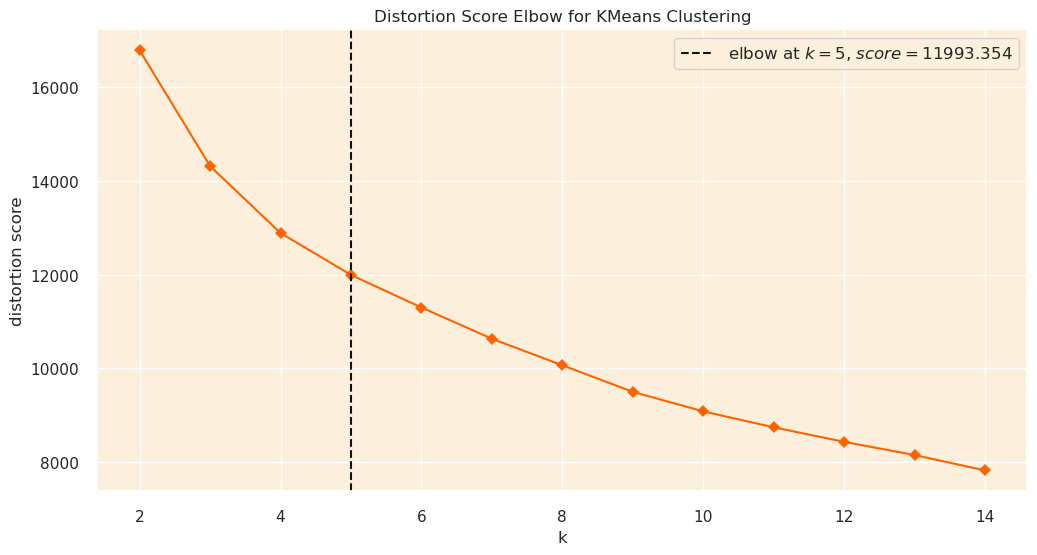

In [70]:
# Set plot style, and background color
sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})

# Set the color palette for the plot
sns.set_palette(['#ff6200'])

# Instantiate the clustering model with the specified parameters
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(12, 6))

# Instantiate the KElbowVisualizer with the model and range of k values, and disable the timing plot
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

# Fit the data to the visualizer
visualizer.fit(customer_data_numeric_imputed)

# Finalize and render the figure
visualizer.show();

### Nº optimo de clusters - Silhouette method

In [71]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    """
    Perform Silhouette analysis for a range of k values and visualize the results.
    """

    # Set the size of the figure
    plt.figure(figsize=figsize)

    # Create a grid with (stop_k - start_k + 1) rows and 2 columns
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    # Assign the first plot to the first row and both columns
    first_plot = plt.subplot(grid[0, :])

    # First plot: Silhouette scores for different k values
    sns.set_palette(['darkorange'])

    silhouette_scores = []

    # Iterate through the range of k values
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    # Add the optimal k value text to the plot
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom', 
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))
             

    # Second plot (subplot): Silhouette plots for each k value
    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):    
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        # Assign the plots to the second, third, and fourth rows
        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        # Add the Silhouette score text to the plot
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()

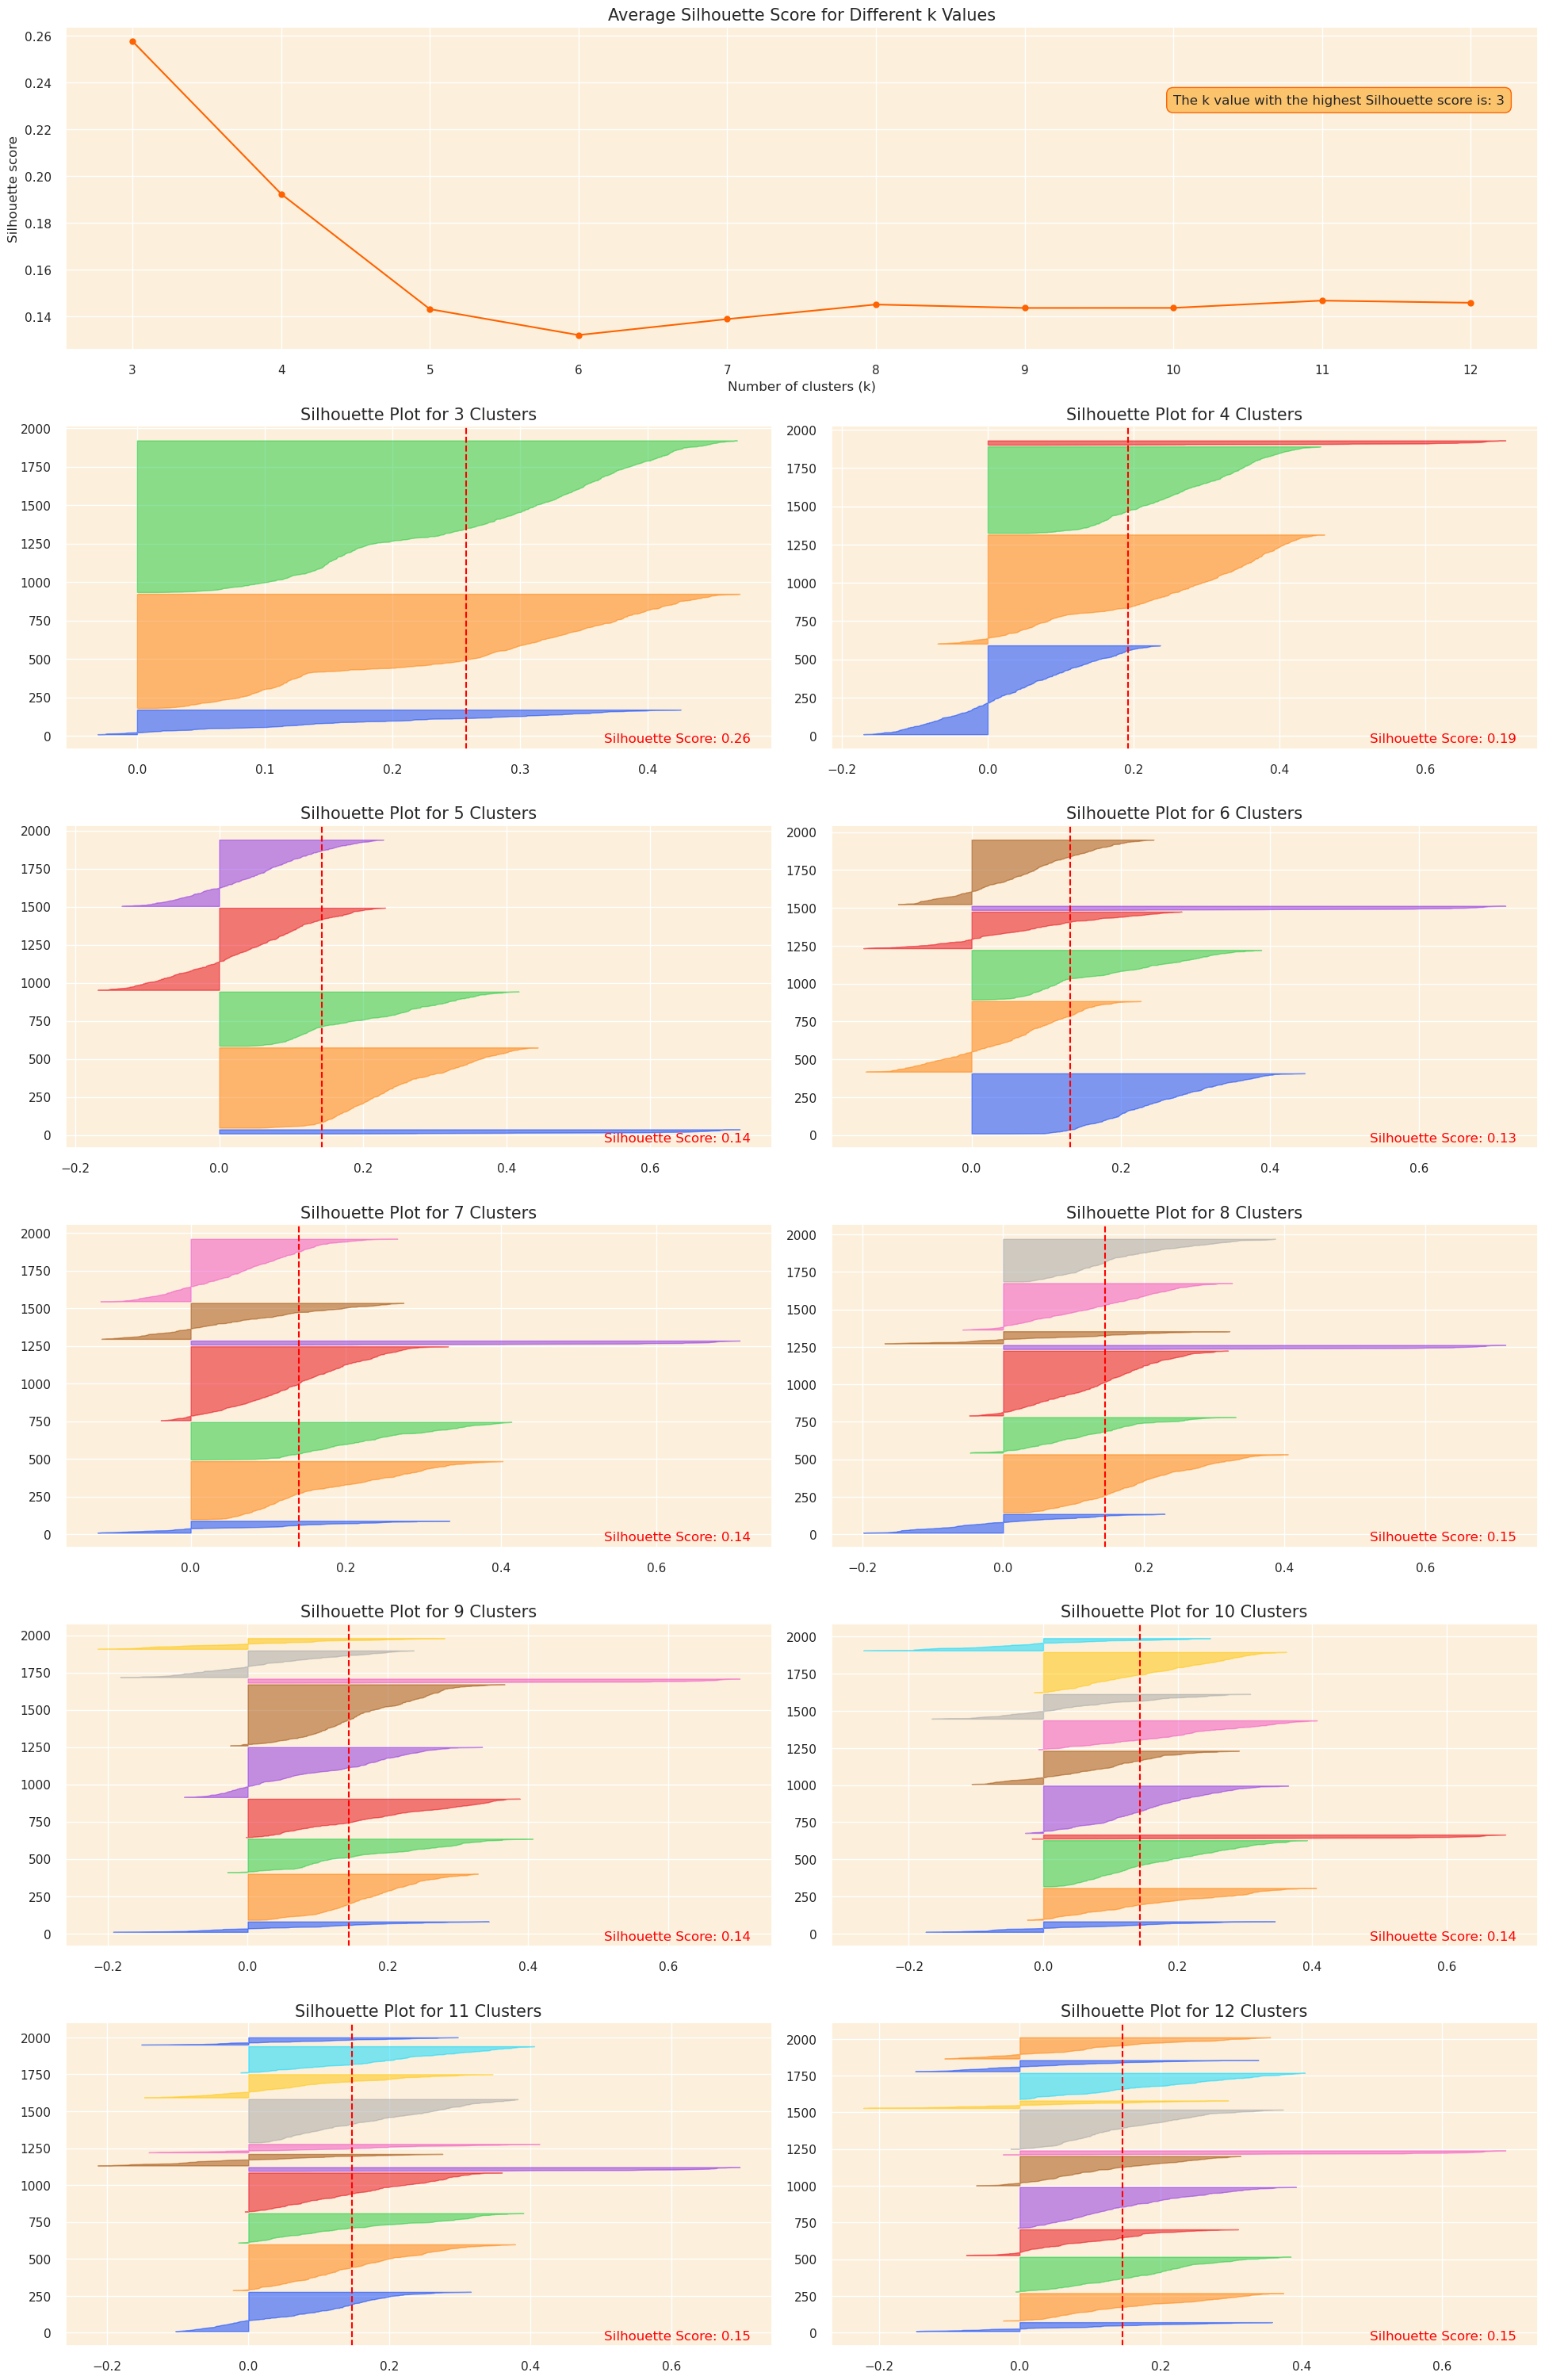

In [72]:
silhouette_analysis(customer_data_numeric_imputed, 3, 12, figsize=(20, 50))

### Clustering com k-means

In [73]:
# Apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_numeric_imputed)

# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)

# Create a mapping from old labels to new labels based on frequency
label_mapping = {label: new_label for new_label, (label, _) in 
                 enumerate(cluster_frequencies.most_common())}

# Reverse the mapping to assign labels as per your criteria
label_mapping = {v: k for k, v in {2: 1, 1: 0, 0: 2}.items()}

# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Append the new cluster labels back to the original dataset
customer_data_cleaned['cluster'] = new_labels

# Append the new cluster labels to the PCA version of the dataset
customer_data_pca['cluster'] = new_labels

In [74]:
# Display the first few rows of the original dataframe
customer_data_cleaned.head()

,ClienteId,Nome,Sexo,EstadoCivil,Profissao,Concelho,Distrito,DataNascimento,Idade,TotalTransacoes,TotalCompras,ProdutosUnicosComprados,Average_Days_Between_Purchases,Day_Of_Week,Hour,Favorite_Shopping_Day,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,cluster
0,104,Diana Castro-Nogueira,F,Casado,Técnico de Marketing,Bragança,Bragança,1956-09-25,68,25,68,24,208.5,5,12,Saturday,682.680423,389.821981,25.012468,1
1,114,Renato Freitas,M,Casado,Aposentado,Vizela,Braga,1961-10-14,63,27,83,25,212.038462,3,12,Thursday,597.376275,486.357222,-8.636573,1
2,116,Luca Anjos,M,Casado,Advogado,Braga,Braga,1973-08-17,51,28,80,23,151.0,2,12,Wednesday,712.652452,474.822652,-15.398387,1
3,117,Mara-Teresa Nogueira,F,Casado,Aposentado,Guimarães,Braga,1970-12-19,54,22,55,21,235.904762,1,12,Tuesday,660.82366,392.662026,-3.102811,1
4,120,Kévim Matos,M,Divorciado,Carpinteiro,Celorico de Basto,Braga,1967-10-18,57,32,100,29,152.677419,2,12,Wednesday,568.29353,399.486435,-6.433073,1


## Avaliação dos clusters

In [75]:
# Setting up the color scheme for the clusters (RGB order)
colors = ['#e8000b', '#1ac938', '#023eff']

In [76]:
# Create separate data frames for each cluster
cluster_0 = customer_data_pca[customer_data_pca['cluster'] == 0]
cluster_1 = customer_data_pca[customer_data_pca['cluster'] == 1]
cluster_2 = customer_data_pca[customer_data_pca['cluster'] == 2]

# Create a 3D scatter plot
fig = go.Figure()

# Add data points for each cluster separately and specify the color
fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'], 
                           mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'], 
                           mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'], 
                           mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))

# Set the title and layout details
fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)

# Show the plot
fig.show()

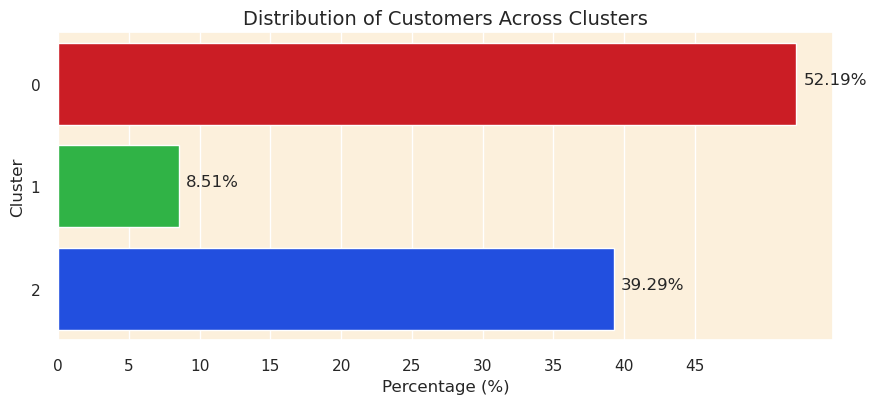

In [77]:
# Calculate the percentage of customers in each cluster
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()

In [78]:
# Compute number of customers
num_observations = len(customer_data_pca)

# Separate the features and the cluster labels
X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']

# Compute the metrics
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

# Create a table to display the metrics and the number of observations
table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

# Print the table
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+--------------------+
|         Metric          |       Value        |
+-------------------------+--------------------+
| Number of Observations  |        1891        |
|    Silhouette Score     | 0.2714746766885531 |
| Calinski Harabasz Score | 583.6004404401581  |
|  Davies Bouldin Score   | 1.2802187010492336 |
+-------------------------+--------------------+


## Profiling

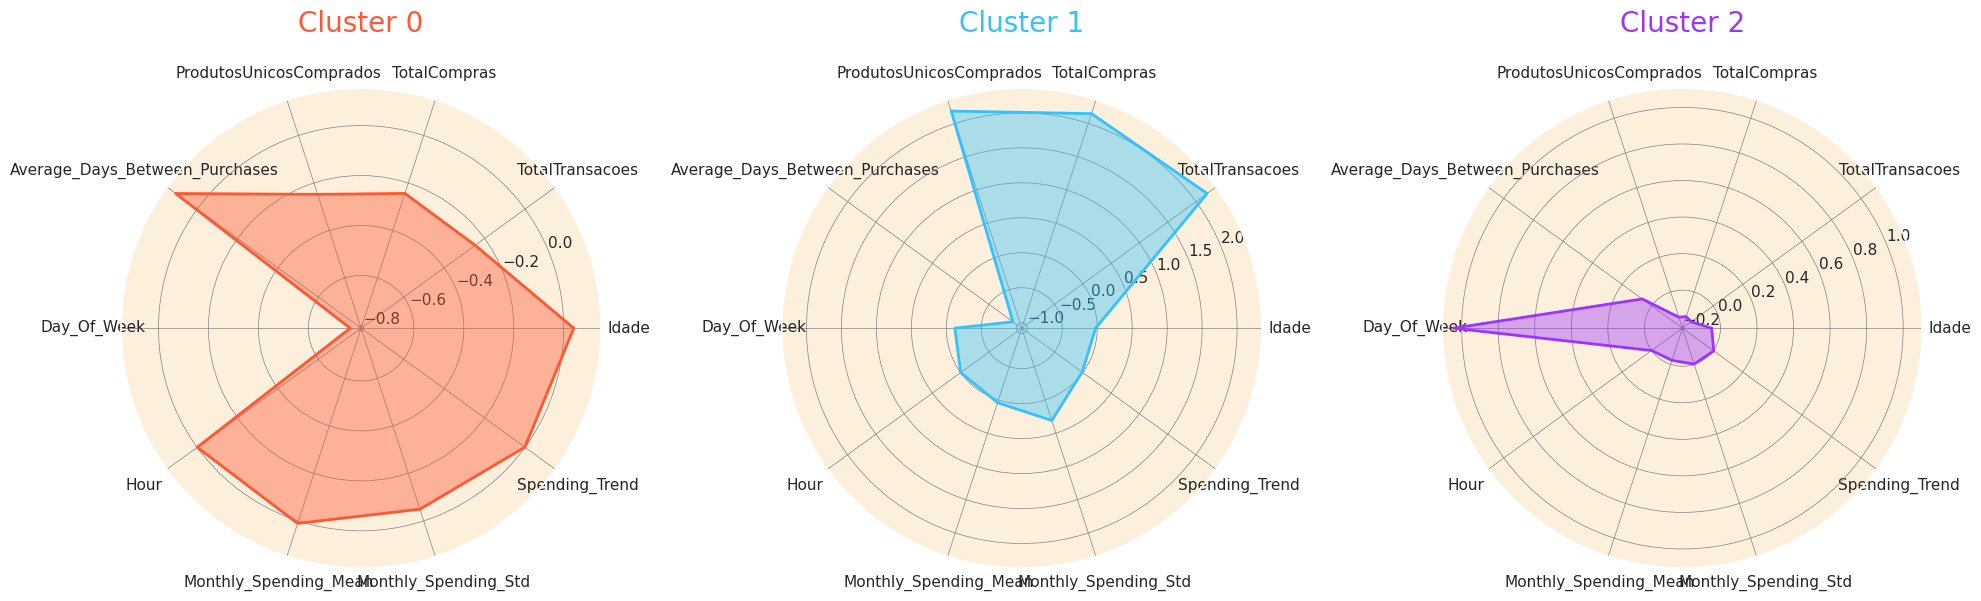

In [79]:
df_customer = customer_data_cleaned.set_index('ClienteId')

# Keep only numeric columns for scaling (excluding 'cluster')
numeric_cols = df_customer.select_dtypes(include=np.number).drop(columns=['cluster'])

# Standardize the numeric data
scaler = StandardScaler()
standardized_values = scaler.fit_transform(numeric_cols)

# Create a DataFrame with standardized values
df_customer_standardized = pd.DataFrame(
    standardized_values,
    columns=numeric_cols.columns,
    index=df_customer.index
)

# Add the 'cluster' column back
df_customer_standardized['cluster'] = df_customer['cluster']

# Calculate the centroids of each cluster
cluster_centroids = df_customer_standardized.groupby('cluster').mean()

# Function to create a radar chart
def create_radar_chart(ax, angles, data, color, cluster):
    # Plot and fill
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')
    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)

# Labels and number of variables
labels = np.array(cluster_centroids.columns)
num_vars = len(labels)

# Compute angles for radar chart
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Complete the loop for circular radar
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

# Colors for clusters (customize as needed)
colors = ['#FF5733', '#33C1FF', '#9D33FF']  # Add or change depending on number of clusters

# Initialize radar chart figure
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(polar=True), nrows=1, ncols=3)

# Create radar charts for each cluster
for i, color in enumerate(colors):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]  # Complete the loop
    create_radar_chart(ax[i], angles, data, color, i)

    # Add labels and grid for each subplot
    ax[i].set_xticks(angles[:-1])
    ax[i].set_xticklabels(labels[:-1])
    ax[i].grid(color='grey', linewidth=0.5)

# Adjust layout and display
plt.tight_layout()
plt.show()


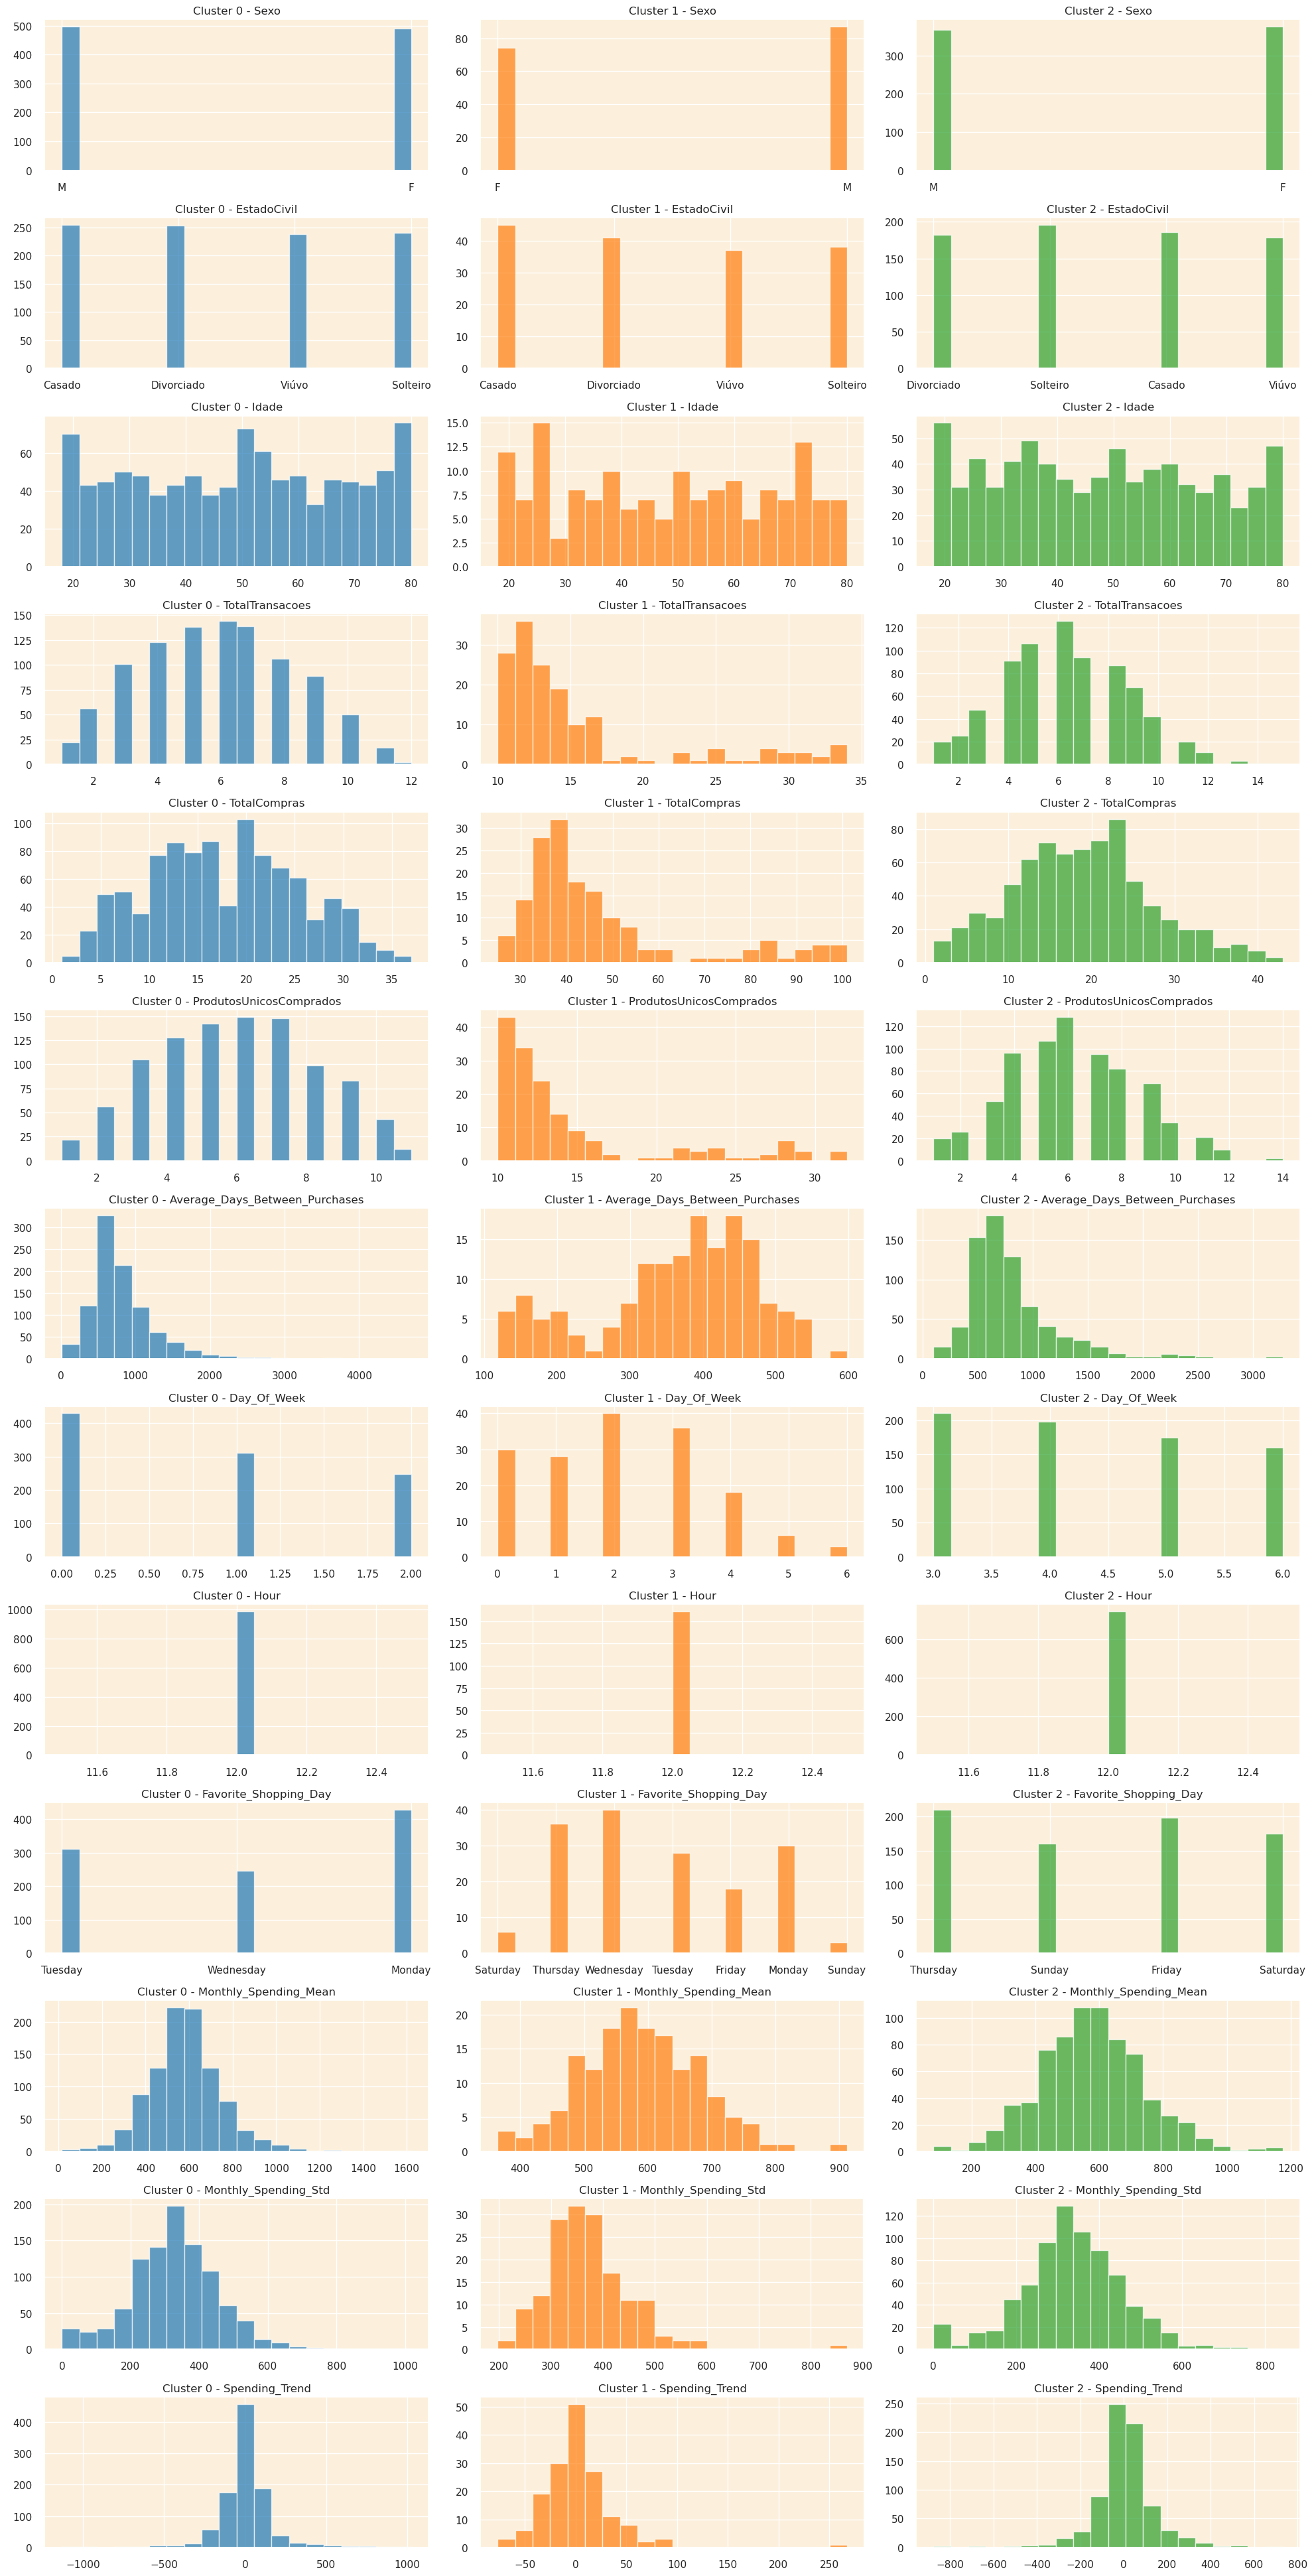

In [80]:
import matplotlib.cm as cm

# Define features and clusters
features = customer_data_cleaned.drop(columns=['ClienteId', 'cluster', 'Nome', 'Profissao', 'Concelho', 'Distrito', 'DataNascimento']).columns
clusters = np.sort(customer_data_cleaned['cluster'].unique())
n_clusters = len(clusters)

# Setup color palette
colors = cm.tab10.colors[:n_clusters]

# Setup subplots
n_rows = len(features)
n_cols = n_clusters
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3 * n_rows))
axes = np.atleast_2d(axes)  # Ensure 2D indexing works

# Plot histograms
for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster][feature]
        axes[i, j].hist(data, bins=20, color=colors[j], edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=12)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

# Tidy up layout
plt.tight_layout()
plt.show()
